# TTim - MODFLOW benchmark

This is the first attempt to reproduce the MODFLOW-benchmark problem in Bakker (2013) that demonstrated the capability of TTim to calculate transient flow with a well, a fixed head canal and a fault and compared with the results of a modflow model.

The model Setup consists of an aquifer system with two permeable layers bounded by leaky layer on top and another in between.

![Aquifer Setup (Bakker, 2013)](aquifer_setup.png)

## Step 1: Import Libraries

In [1]:
import flopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Step 2: Declaring the Well Information

In [2]:
# Well location:
x_well = 0
y_well = 0

#Well Pumping:

Q = 500 #m3/d
t = 0 #Start of the pumping


## Step 3: Location of the Canal

In [3]:
x_canal = 200
y_min_canal = -410
y_max_canal = 410

## Step 4: Location of the Fault

In [4]:
x_fault = -200
y_min_fault = y_min_canal
y_max_fault = y_max_canal

## Step 5: Building the MODFLOW model using Flopy

In [5]:
delx = 20 #Grid information from the paper (Bakker, 2013)
dely = 20
nrow = 201
ncol = nrow
nlay = 3

## Aquifer Parameters:
Ss = 1e-4 # Specific Storage
c = 1000 # Vertical resistance (days)
L = 1/c # Leakance [1/days]
T_aq1 = 100 #Transmissivity of the first aquifer
T_aq2 = 200 #Transmissivity of the second aquifer

top = 0
botm = [-20,-40, -60]

### Step 5.1. Initiating the modflow model:

In [6]:
modelname = "ttim_benchmark"
mf = flopy.modflow.Modflow(modelname, exe_name="mf2005")

### Step 5.2. Creating the DIS package:

In [7]:
dis = flopy.modflow.ModflowDis(
    mf,
    nlay,
    nrow,
    ncol,
    delr=delx,
    delc=dely,
    top=0,
    botm=botm,
    nper=1,
    perlen=1,
    nstp=50,
    steady=False,
    xul = -(20*100+10),
    yul = (20*100+10)
)

### Step 5.3: Creating the PCG Package:

In [8]:
pcg = flopy.modflow.ModflowPcg(mf)

### Step 5.4. Defining the Leakance array, including a leakance of 1 in the cells that are in the fault area.

In [9]:
Leakance = np.ones((2,nrow,ncol))*L

Leakance[1,79:121, 90] = 1

np.sum(Leakance == 1)

42

### Step 5.5. Defining the BCF package from the leakance array above and the aquifer parameters

In [10]:
bcf = flopy.modflow.ModflowBcf(
    mf, laycon = 0, tran =[T_aq1, T_aq1, T_aq2], sf1=Ss, ipakcb=53, vcont = Leakance
)

#### Checking the leakance array in the model (layer 2):

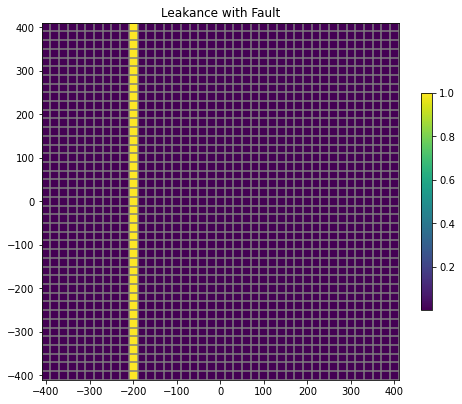

In [11]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Leakance with Fault')
mapview = flopy.plot.PlotMapView(model=mf, layer=1, extent = (-410,410,-410,410))
quadmesh = mapview.plot_array(Leakance)
linecollection = mapview.plot_grid()
cb = plt.colorbar(quadmesh, shrink=0.5)

In [12]:
print(dis.get_rc_from_node_coordinates(x_canal,y_min_canal, local = False))
dis.get_rc_from_node_coordinates(x_canal,y_max_canal, local = False)


(120, 110)


(79, 110)

### Step 5.6. Defining the IBOUND array, assiging fixed head cells at the canal

In [13]:
ibound = np.ones((nlay,nrow,ncol))
ibound[0,:,:] = -1
ibound[1,79:121,110] = -1

### Step 5.7. Creating the BAS package

In [14]:
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=0)

In [15]:
dis.get_rc_from_node_coordinates(x_well,y_well, local = False)

(100, 100)

### Step 5.8. Creating the WEL stress period data and the WEL package

In [16]:
stress_data = [2,100,100,-500]
stress_period = {}
stress_period[0] = stress_data

wel = flopy.modflow.ModflowWel(mf, stress_period_data=stress_period)

### Step 5.9. Creating the OC package

In [17]:
stress_period_data = {}
for kstp in range(50):
    stress_period_data[(0, kstp)] = [
        "save head",
        "save drawdown",
        "save budget",
        "print head",
        "print budget",
    ]
oc = flopy.modflow.ModflowOc(
    mf, stress_period_data=stress_period_data, compact=True
)

### Step 5.10: Writing and running the MODFLOW model

In [18]:
# Write the model input files
mf.write_input()

# Run the model
success, mfoutput = mf.run_model(silent=True, pause=False)
if not success:
    raise Exception("MODFLOW did not terminate normally.")

In [19]:
import flopy.utils.binaryfile as bf

## Step 6. Plotting the Results

In [20]:
# Create the headfile and budget file objects
headobj = bf.HeadFile(modelname + ".hds")
times = headobj.get_times()
print(times)
cbb = bf.CellBudgetFile(modelname + ".cbc")

[0.02, 0.04, 0.06, 0.08, 0.099999994, 0.11999999, 0.13999999, 0.15999998, 0.17999998, 0.19999997, 0.21999997, 0.23999996, 0.25999996, 0.27999997, 0.29999998, 0.32, 0.34, 0.36, 0.38000003, 0.40000004, 0.42000005, 0.44000006, 0.46000007, 0.48000008, 0.50000006, 0.52000004, 0.54, 0.56, 0.58, 0.59999996, 0.61999995, 0.6399999, 0.6599999, 0.6799999, 0.69999987, 0.71999985, 0.73999983, 0.7599998, 0.7799998, 0.7999998, 0.81999975, 0.83999974, 0.8599997, 0.8799997, 0.8999997, 0.91999966, 0.93999964, 0.9599996, 0.9799996, 0.9999996]


In [21]:
# Setup contour parameters
levels = np.linspace(-5, 0, 80)
extent = (-420, 420, -420,420)
print("Levels: ", levels)
print("Extent: ", extent)

Levels:  [-5.         -4.93670886 -4.87341772 -4.81012658 -4.74683544 -4.6835443
 -4.62025316 -4.55696203 -4.49367089 -4.43037975 -4.36708861 -4.30379747
 -4.24050633 -4.17721519 -4.11392405 -4.05063291 -3.98734177 -3.92405063
 -3.86075949 -3.79746835 -3.73417722 -3.67088608 -3.60759494 -3.5443038
 -3.48101266 -3.41772152 -3.35443038 -3.29113924 -3.2278481  -3.16455696
 -3.10126582 -3.03797468 -2.97468354 -2.91139241 -2.84810127 -2.78481013
 -2.72151899 -2.65822785 -2.59493671 -2.53164557 -2.46835443 -2.40506329
 -2.34177215 -2.27848101 -2.21518987 -2.15189873 -2.08860759 -2.02531646
 -1.96202532 -1.89873418 -1.83544304 -1.7721519  -1.70886076 -1.64556962
 -1.58227848 -1.51898734 -1.4556962  -1.39240506 -1.32911392 -1.26582278
 -1.20253165 -1.13924051 -1.07594937 -1.01265823 -0.94936709 -0.88607595
 -0.82278481 -0.75949367 -0.69620253 -0.63291139 -0.56962025 -0.50632911
 -0.44303797 -0.37974684 -0.3164557  -0.25316456 -0.18987342 -0.12658228
 -0.06329114  0.        ]
Extent:  (-420, 42

### Map view of heads Layers 1 and 2:

<a list of 23 text.Text objects>

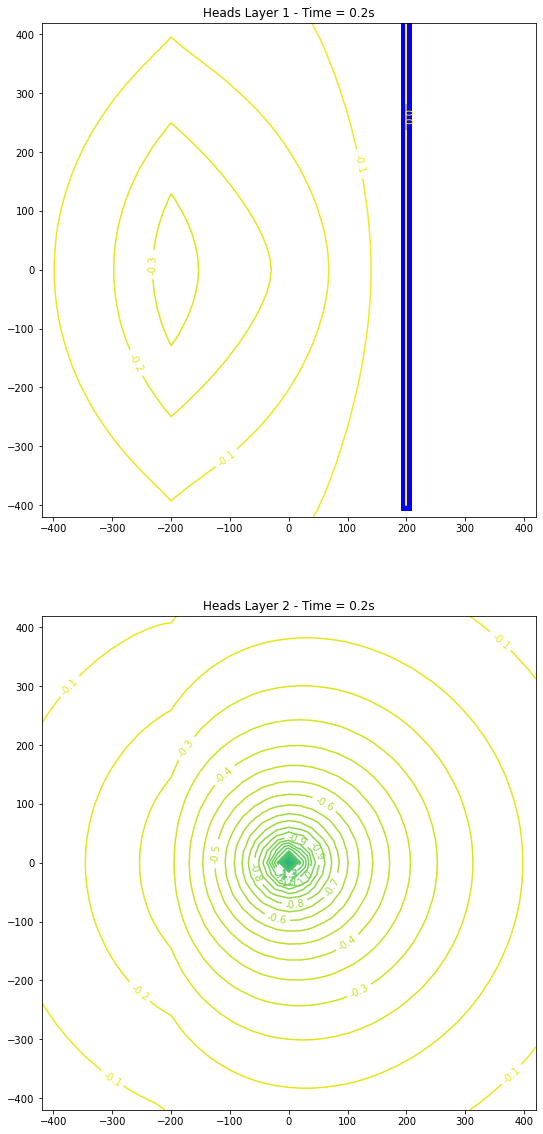

In [22]:
# Make the plots
fig = plt.figure(figsize = (10,20))
ax1 = fig.add_subplot(2,1,1, aspect = 'equal')
ax2 = fig.add_subplot(2,1,2, aspect = 'equal')
time = times[9] #This is the 0.2 s head time
#Load head data:
head = headobj.get_data(totim=time)
    
# Extract flow right face and flow front face
frf = cbb.get_data(text="FLOW RIGHT FACE", totim=time)[0]
fff = cbb.get_data(text="FLOW FRONT FACE", totim=time)[0]

# Create a map for this time

ax1.set_title("Heads Layer 1 - Time = 0.2s")

pmv1 = flopy.plot.PlotMapView(model=mf, layer=1, ax=ax1, extent = extent)

qm1 = pmv1.plot_ibound()
cs = pmv1.contour_array(head, levels=levels, extent = extent)
plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")
#quiver1 = pmv1.plot_vector(frf, fff, istep = 5, jstep = 10)

ax2.set_title("Heads Layer 2 - Time = 0.2s")
pmv2 = flopy.plot.PlotMapView(model=mf, layer=2, ax=ax2, extent = extent)

qm2 = pmv1.plot_ibound()
cs2 = pmv2.contour_array(head, levels=levels, extent = extent)
plt.clabel(cs2, inline=1, fontsize=10, fmt="%1.1f")
#quiver2 = pmv2.plot_vector(frf, fff, istep = 5, jstep = 10)

Text(0.5, 0.98, 'Cross section - Model Heads')

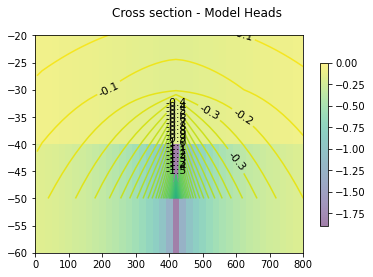

In [23]:
line = np.array([(0,-410),(0,410)])
extent = (0,800,-60,-20)
xsect = flopy.plot.PlotCrossSection(mf, line= { "line": line}, extent = extent)
pc = xsect.plot_array(head, masked_values=[999.], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head)
contour = xsect.contour_array(head, masked_values=[999.], head=head, levels=levels, linewidths=1.5)
plt.clabel(contour, fmt='%.1f', colors='k', fontsize=11)
cb = plt.colorbar(pc, shrink=0.75)
plt.suptitle("Cross section - Model Heads")

### Plot heads such as in the paper:

Text(0.5, 1.0, 'Heads at t = 0.2 days in each layer, y = 0')

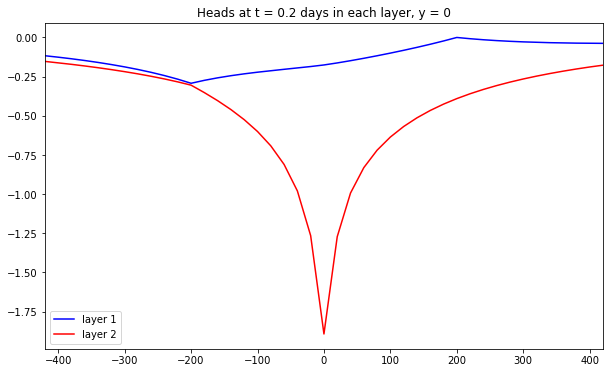

In [24]:
heads_l1 = head[1,100,:]
heads_l1
heads_l2 = head[2,100,:]
x_dir = np.linspace(-2000,2000,201)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(x_dir, heads_l1, '-', color = 'b', label = 'layer 1')
ax.plot(x_dir, heads_l2, '-', color = 'r', label = 'layer 2')
ax.legend()
ax.set_xlim([-420,420])
ax.set_title('Heads at t = 0.2 days in each layer, y = 0')

## Step 7. Calculate flow from fault (fff) and flow from canal (ffc)

In [25]:
idx = []
for row in range(79,121):
    idx.append((1,row,90))
fff = cbb.get_ts(idx = idx, text="FLOW LOWER FACE")

idx = []

for row in range(79,121):
    idx.append((1,row, 110))

ffc = cbb.get_ts(idx, "CONSTANT HEAD")

#ffc

### Step 7.1. Plot Flows from fault and from canal

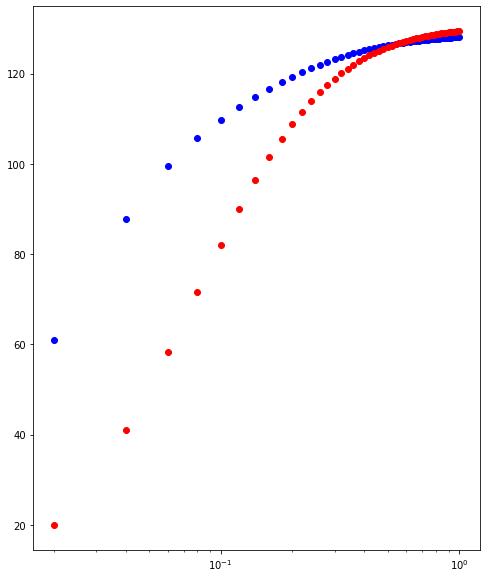

In [26]:
flow = np.sum(fff, axis = 1)
flow.shape

canal = np.sum(ffc, axis = 1)

fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(1, 1, 1)


ax.plot(times, flow, "bo")
ax.plot(times, canal, 'ro')
ax.set_xscale('log')

## Step 8. Create TTim Model:

In [27]:
from ttim import * # TTim model
ml = ModelMaq( kaq = [10, 20],
z = [30, 25, 15, 10, 0], c = [1000, 1000], Saq = [1e-4, 1e-4], topboundary = 'semi', tmin = 1e-2, tmax = 10 )
w = Well(ml, xw = 0, yw = 0, rw = 0.1, tsandQ = [(0,500)], layers = 1 )
xfault = -200 * np.ones(21)

#Defining the fault (Is this correct?)
ls1 = LeakyLineDoublet( ml, x_fault, y_min_fault, x_fault, y_max_fault, res = 1, layers=[0,1] )

#Defining the canal
ls2 = HeadLineSink( ml, x_canal, y_min_canal, x_canal, y_max_canal, [(0,0)], layers=[0] )
ml.solve()
# Compute head: ml.head(x,y,t) ml.head(100,100,[1,2,3,4,5]

self.neq  4
solution complete


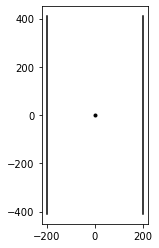

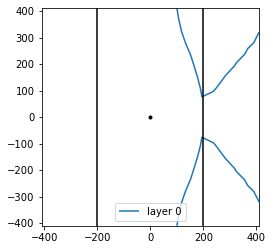

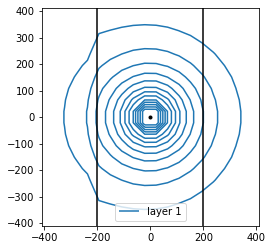

In [28]:
ml.plot()
ml.contour(t = 0.2, win = [-410,410,-410,410], layers = 0, levels = levels)
ml.contour(t = 0.2, win = [-410,410,-410,410], layers = 1, levels = levels)

## Step 9. Comparing TTim and MODFLOW results

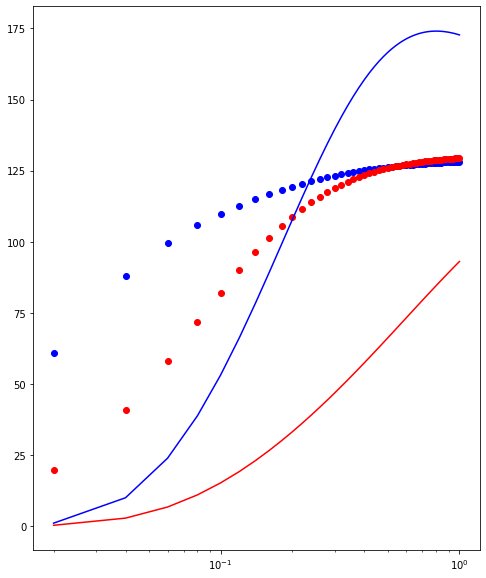

In [29]:
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(1, 1, 1)


ax.plot(times, flow, "bo")
ax.plot(times, canal, 'ro')
ax.plot(times, ls1.discharge(times)[0], 'b-')
ax.plot(times, -1*ls2.discharge(times)[0], 'r-')
ax.set_xscale('log')

Text(0.5, 1.0, 'Heads at t = 0.2 days in each layer, y = 0, comparing TTim and MODFLOW')

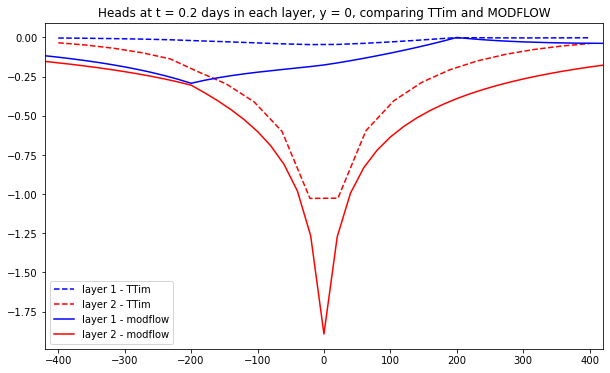

In [32]:
# Head along line:

h1 = np.squeeze(ml.headalongline(x = np.linspace(-400,400,20), y = np.repeat(0,20),t = 0.2, layers = 0 ))
h2 = np.squeeze(ml.headalongline(x = np.linspace(-400,400,20), y = np.repeat(0,20),t = 0.2, layers = 1 ))

x_dir_ttim = np.linspace(-400,400,20)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(x_dir_ttim, h1, '--', color = 'b', label = 'layer 1 - TTim')
ax.plot(x_dir_ttim, h2, '--', color = 'r', label = 'layer 2 - TTim')
ax.plot(x_dir, heads_l1, '-', color = 'b', label = 'layer 1 - modflow')
ax.plot(x_dir, heads_l2, '-', color = 'r', label = 'layer 2 - modflow')
ax.legend()
ax.set_xlim([-420,420])
ax.set_title('Heads at t = 0.2 days in each layer, y = 0, comparing TTim and MODFLOW')